In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

from torch.cuda.amp import GradScaler, autocast

from torchvision import datasets, transforms



In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [69]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST('.',train=True,transform=transform,download=True)
test_ds = datasets.MNIST('.',train=False,transform=transform,download=True)

In [64]:
train_loader = DataLoader(train_ds,128,shuffle=True)
test_loader = DataLoader(test_ds,128,shuffle=False)

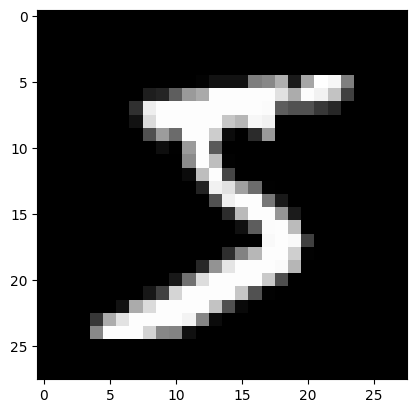

In [65]:
import matplotlib.pyplot as plt
img, label = train_ds[0]
plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [66]:
class SmallModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.depthwise1 = nn.Conv2d(1,1,3,1,1,groups=1)
        self.pointwise1 = nn.Conv2d(1,16,1)
        self.depthwise2 = nn.Conv2d(16,16,3,1,1,groups=1)
        self.pointwise2 = nn.Conv2d(16,32,1)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32*7*7,10)
        
        
    def forward(self,x):
        x = self.depthwise1(x)
        x = self.pointwise1(x)
        x = self.relu(x)
        x = self.pooling(x)

        x = self.depthwise2(x)
        x = self.pointwise2(x)
        x = self.relu(x)
        x = self.pooling(x)


        x = self.flatten(x)
        x = self.fc(x)


        return x

In [67]:
model  = SmallModel().to(device)
optimizer = optim.Adam(model.parameters(), lr =1e-3)
criterion = nn.CrossEntropyLoss()


In [76]:
for epoch in range(3):
    model.train()
    for x,y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits,y)
        loss.backward()
        optimizer.step()
        print(f"train: epoch- {epoch} loss- {loss}")        
    
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in test_loader:
            preds = model(x).argmax(1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    print(f"epoch {epoch}: acc = {correct/total}")
         

train: epoch- 0 loss- 1.9635611772537231
train: epoch- 0 loss- 1.8779984712600708
train: epoch- 0 loss- 1.8802233934402466
train: epoch- 0 loss- 1.791225790977478
train: epoch- 0 loss- 1.749695897102356
train: epoch- 0 loss- 1.7367814779281616
train: epoch- 0 loss- 1.7647364139556885
train: epoch- 0 loss- 1.6930867433547974
train: epoch- 0 loss- 1.6628568172454834
train: epoch- 0 loss- 1.5908571481704712
train: epoch- 0 loss- 1.5972936153411865
train: epoch- 0 loss- 1.6022238731384277
train: epoch- 0 loss- 1.5629459619522095
train: epoch- 0 loss- 1.4564836025238037
train: epoch- 0 loss- 1.4211452007293701
train: epoch- 0 loss- 1.411738634109497
train: epoch- 0 loss- 1.4141845703125
train: epoch- 0 loss- 1.3585628271102905
train: epoch- 0 loss- 1.3636906147003174
train: epoch- 0 loss- 1.3106640577316284
train: epoch- 0 loss- 1.362160325050354
train: epoch- 0 loss- 1.268776535987854
train: epoch- 0 loss- 1.0951611995697021
train: epoch- 0 loss- 1.1929583549499512
train: epoch- 0 loss- 1.

In [77]:
## inference
model.eval()
example_input = torch.randn(1, 1, 28, 28).to(device)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("tinycnn_mnist.pt")
print("Model saved as tinycnn_mnist.pt")

Model saved as tinycnn_mnist.pt


In [78]:
loaded_model = torch.jit.load("tinycnn_mnist.pt")
loaded_model.to(device)
loaded_model.eval()
print("Model loaded and ready for inference")

Model loaded and ready for inference


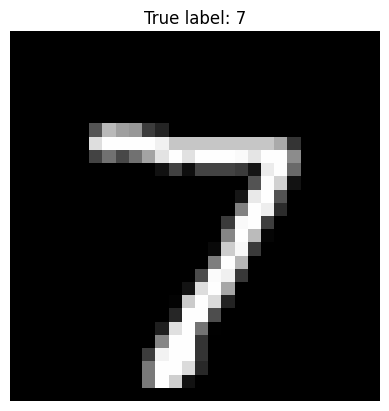

Predicted: 7


In [79]:
import matplotlib.pyplot as plt

img, label = test_ds[0]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"True label: {label}")
plt.axis('off')
plt.show()

x = img.unsqueeze(0).to(device)

with torch.no_grad():
    logits = loaded_model(x)
    pred = logits.argmax(1).item()

print("Predicted:", pred)